# Benchmark model tuning

This notebook presents timing results for multiple traces model tuning using different resources.

In [1]:
from pathlib import Path
from subprocess import run
from io import StringIO
from itertools import dropwhile

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

sb.set()

In [2]:
dset = pd.DataFrame(
    [
        [33166067, 3, 9, 1],
        [33166079, 2, 6, 1],
        [33166081, 1, 3, 1],
        [33170243, 1, 1, 1],
        [33170257, 1, 3, 1],
        [33170258, 2, 6, 1],
        [33170261, 3, 9, 1],
        [33170270, 4, 12, 1],
        [33179306, 2, 6, 2],
    ],
    columns=["jobid", "n_jobs", "n_workers", "n_gpu"],
)
dset

,jobid,n_jobs,n_workers,n_gpu
0,33166067,3,9,1
1,33166079,2,6,1
2,33166081,1,3,1
3,33170243,1,1,1
4,33170257,1,3,1
5,33170258,2,6,1
6,33170261,3,9,1
7,33170270,4,12,1
8,33179306,2,6,2


In [3]:
dset_jobs = []

for _, row in dset.iterrows():
    ret = run(
        f"sacct -j {row['jobid']} -o JobID,State --parsable2",
        shell=True,
        capture_output=True,
    )
    dset_job = pd.read_csv(StringIO(ret.stdout.decode()), delimiter="|").iloc[::3]
    dset_job = dset_job.assign(**row.drop("jobid"))
    dset_jobs.append(dset_job)

dset_jobs = pd.concat(dset_jobs)

In [4]:
def parse_log(jobid):
    filepath = next(Path("../logs").glob(f"{jobid}-tune_darts_lstm_benchmark*.sl.out"))
    with filepath.open("r") as fd:
        lines = dropwhile(lambda x: not x.startswith("real"), fd)
        res = pd.Timedelta(next(lines).strip().split("\t")[-1]).total_seconds()
    return res

In [5]:
dset_jobs["duration"] = dset_jobs.apply(lambda x: parse_log(x["JobID"]), axis=1)

In [6]:
dset_jobs

,JobID,State,n_jobs,n_workers,n_gpu,duration
0,33166067_0,COMPLETED,3,9,1,971.243
3,33166067_1,COMPLETED,3,9,1,907.342
6,33166067_2,FAILED,3,9,1,1145.523
9,33166067_3,COMPLETED,3,9,1,2512.787
12,33166067_4,COMPLETED,3,9,1,1141.502
...,...,...,...,...,...,...
105,33179306_35,COMPLETED,2,6,2,823.833
108,33179306_36,COMPLETED,2,6,2,1363.279
111,33179306_37,COMPLETED,2,6,2,3718.920
114,33179306_38,COMPLETED,2,6,2,1953.103


In [7]:
dset_jobs["condition"] = dset_jobs.apply(
    lambda x: f"{x['n_workers']} workers - {x['n_gpu']} GPU", axis=1
)

<AxesSubplot: xlabel='condition', ylabel='duration'>

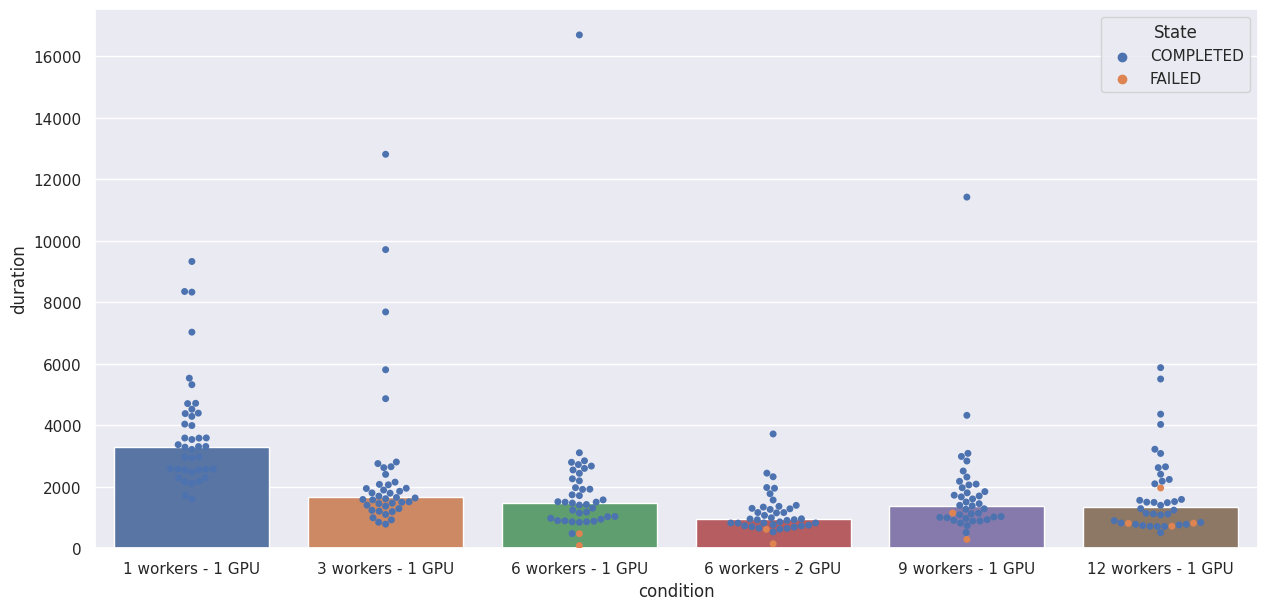

In [8]:
_, ax = plt.subplots(figsize=(15, 7))
order = dset_jobs.sort_values(["n_workers", "n_gpu"])["condition"].unique()
sb.barplot(
    data=dset_jobs,
    x="condition",
    y="duration",
    estimator="median",
    order=order,
    ax=ax,
    errorbar=None,
)
sb.swarmplot(
    data=dset_jobs,
    x="condition",
    y="duration",
    hue="State",
    edgecolor="gray",
    order=order,
    ax=ax,
)

(0.0, 4500.0)

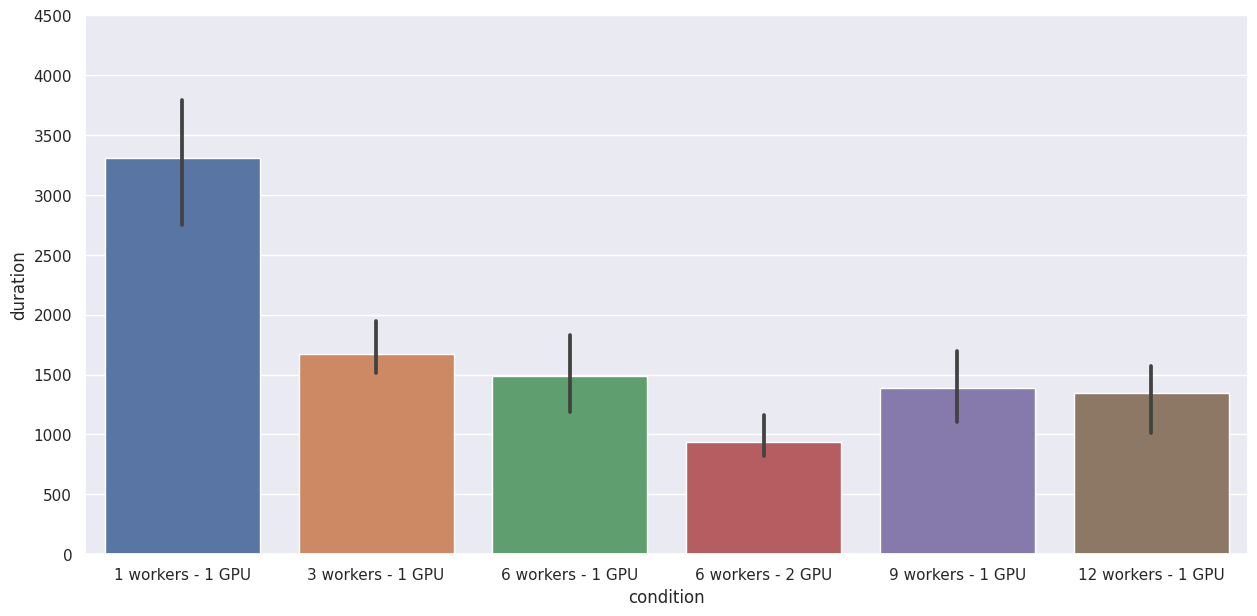

In [9]:
_, ax = plt.subplots(figsize=(15, 7))
sb.barplot(
    data=dset_jobs, x="condition", y="duration", estimator="median", order=order, ax=ax
)
ax.set_ylim([0, 4500])